In [19]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [21]:
BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULE_PATH = os.path.join(BASE_PATH, "modules")
DATASET_PATH = os.path.join(BASE_PATH, "datasets")

In [22]:
sys.path.append(MODULE_PATH)

In [23]:
from data import BenchmarkData, DataSetType
from bayesian import McDropout
from models import ygal_cnn, fchollet_cnn, setup_growth
from active_learning import AcquisitionFunction

In [42]:
mnist_path = os.path.join(DATASET_PATH, "mnist")
num_classes = 5
mnist = BenchmarkData(DataSetType.MNIST, mnist_path, dtype=float, classes=num_classes)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(mnist.inputs, mnist.targets)

In [44]:
setup_growth()

1 Physical GPU's,  1 Logical GPU's


# Using Adam optimizer

In [67]:
o_model = fchollet_cnn(output=num_classes)
o_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
o_model.fit(x_test[:10], y_test[:10], epochs=5, batch_size=10)

Epoch 1/5
1/1 [==============================] - 0s 693us/step - loss: 47.3642 - accuracy: 0.3000
Epoch 2/5
1/1 [==============================] - 0s 636us/step - loss: 57.7710 - accuracy: 0.4000
Epoch 3/5
1/1 [==============================] - 0s 674us/step - loss: 53.7279 - accuracy: 0.4000
Epoch 4/5
1/1 [==============================] - 0s 841us/step - loss: 55.0652 - accuracy: 0.3000
Epoch 5/5
1/1 [==============================] - 0s 899us/step - loss: 27.1694 - accuracy: 0.5000


In [68]:
def predict(data, model, num_predictions):
    
    predictions = []
    
    for n in range(num_predictions):
        output = model(data, training=True)
        predictions.append(output)
        
    return np.stack(predictions, axis=1)

In [69]:
num_samples = 100
outputs = predict(x_test[10:20], o_model, num_samples)

In [70]:
classes = list(range(num_classes))*num_samples

Text(0, 0.5, 'Probability')

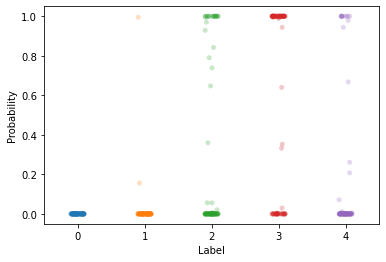

In [73]:
# Barely converged adam
df = pd.DataFrame({
    "prediction": outputs[1].flatten(),
    "labels": classes
})

sns.stripplot(data=df, y="prediction", x="labels", alpha=.25)
plt.xlabel("Label")
plt.ylabel("Probability")

In [54]:
pred = np.argmax(np.mean(outputs, axis=1), axis=1)
pred

array([2, 1, 2, 3, 2, 2, 2, 2, 2, 0])

In [55]:
y_test[10:20]

array([0, 1, 4, 3, 3, 1, 2, 1, 4, 0], dtype=uint8)

In [56]:
np.mean(pred == y_test[10:20])

0.4

In [74]:
o_model.fit(x_test[:10], y_test[:10], epochs=50, batch_size=10)

Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 26.8049 - accuracy: 0.6000
Epoch 2/50
1/1 [==============================] - 0s 803us/step - loss: 14.0615 - accuracy: 0.6000
Epoch 3/50
1/1 [==============================] - 0s 772us/step - loss: 16.0932 - accuracy: 0.4000
Epoch 4/50
1/1 [==============================] - 0s 700us/step - loss: 0.6917 - accuracy: 0.9000
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 2.0600 - accuracy: 0.9000
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1634 - accuracy: 0.9000
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/50
1/1 [==============================] - 0s 1ms/step - loss: 3.0461 - accuracy: 0.9000
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.9000
Epoch 11/50
1/1 [=====

<AxesSubplot:xlabel='labels', ylabel='prediction'>

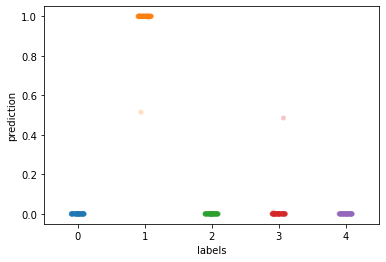

In [76]:
# Fully learned network
outputs = predict(x_test[10:20], o_model, num_samples)
classes = list(range(num_classes))*num_samples
df = pd.DataFrame({
    "prediction": outputs[1].flatten(),
    "labels": classes
})
sns.stripplot(data=df, y="prediction", x="labels", alpha=.25)

# Using SGD

In [78]:
from tensorflow.keras.optimizers import SGD

model = McDropout(fchollet_cnn(output=num_classes))
optimizer = SGD(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)
model.fit(x_train[:300], y_train[:300], epochs=5, batch_size=20)

Epoch 1/5
15/15 [==============================] - 0s 2ms/step - loss: 15.5433
Epoch 2/5
15/15 [==============================] - 0s 2ms/step - loss: 1.0841
Epoch 3/5
15/15 [==============================] - 0s 2ms/step - loss: 0.6332
Epoch 4/5
15/15 [==============================] - 0s 3ms/step - loss: 0.4639
Epoch 5/5
15/15 [==============================] - 0s 3ms/step - loss: 0.4065


In [82]:
# Fully learned network
outputs = predict(x_test[10:20], model, num_samples)

In [89]:
outputs[1].shape

(100, 10, 5)

In [85]:
len(classes)

500

In [83]:

df = pd.DataFrame({
    "prediction": outputs[1].flatten(),
    "labels": classes
})
sns.stripplot(data=df, y="prediction", x="labels", alpha=.25)

ValueError: arrays must all be same length